<a href="https://colab.research.google.com/github/Saran-nns/traja-research/blob/master/ForecastingJaguarLSTMCategoricalVAEGAN6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/traja-team/traja.git
# !cd traja && git checkout NeuralNetworks
# !wget justinshenk.com/share/E1_E2.csv
!git clone https://github.com/traja-team/traja-research.git
!cd traja-research && git checkout dataset_und_notebooks

Cloning into 'traja-research'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (305/305), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 305 (delta 85), reused 257 (delta 46), pack-reused 0
Receiving objects: 100% (305/305), 20.29 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Branch 'dataset_und_notebooks' set up to track remote branch 'dataset_und_notebooks' from 'origin'.
Switched to a new branch 'dataset_und_notebooks'


In [ ]:
# import sys; sys.path.append('./traja')
# import traja
from random import randint
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.autograd import Variable

### Plot defaults

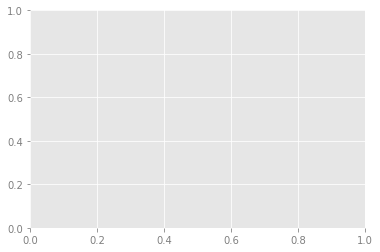

In [ ]:
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.ticklabel_format(useOffset=False)

### Data preprocessing

#### Data

In [ ]:
# trjs = pd.read_csv("E1_E2.csv")
# trjs.dropna(subset=['x','y'],inplace=True)
# axes = ['x', 'y', 'hour', 'day', 'ID']
# trjs = trjs.filter(items=axes).replace(['E1', 'E2'], [0, 1])
# trjs = trjs[['x','y']][:50000]

In [ ]:
trjs = pd.read_csv('./traja-research/dataset_analysis/jaguar117/jaguar_movement_data.csv')
print('IDs/Animal trajectories in the dataset',trjs['individual.local.identifier (ID)'].unique())
trjs.head()

IDs/Animal trajectories in the dataset [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Event_ID,timestamp,location.long,location.lat,individual.taxon.canonical.name,tag.local.identifier,individual.local.identifier (ID),study.name,country
0,1.0,6/15/10 22:43,-58.030128,-23.326947,Panthera onca,0-333005,1,Humid Chaco,Paraguay
1,2.0,6/16/10 2:52,-58.030643,-23.328427,Panthera onca,0-333005,1,Humid Chaco,Paraguay
2,3.0,6/16/10 22:36,-58.030472,-23.327311,Panthera onca,0-333005,1,Humid Chaco,Paraguay
3,4.0,6/17/10 16:42,-58.027983,-23.309952,Panthera onca,0-333005,1,Humid Chaco,Paraguay
4,5.0,6/17/10 20:37,-58.027747,-23.310006,Panthera onca,0-333005,1,Humid Chaco,Paraguay


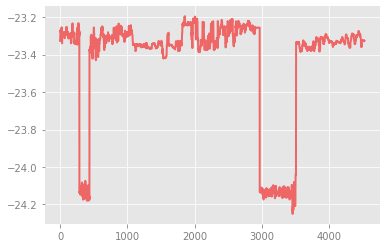

In [ ]:
# Filter IDs, Latitude and longitude columns and rename them 
dataset_traj = trjs[['location.long','location.lat','individual.local.identifier (ID)']]
IDs = list(range(10))
dataset_traj_ = dataset_traj[dataset_traj['individual.local.identifier (ID)'].isin(IDs)]
dataset_traj_['individual.local.identifier (ID)'].unique()
dataset_traj_ = dataset_traj_.rename(columns={"individual.local.identifier (ID)": "ID","location.long":"x", 
                                              "location.lat":"y"})
# plt.plot(dataset_traj_['x'])
# plt.savefig('x.png')
plt.plot(dataset_traj_['y'])
plt.savefig('y.png')

#### Data Train-Test Split and Scaling

In [ ]:
def generate_dataset(df, n_past, n_future):
    """
    df : Dataframe
    n_past: Number of past observations
    n_future: Number of future observations
    Returns:
    X: Past steps
    Y: Future steps (Sequence target)
    Z: Sequence category""" 
    
    # Split the dataframe with respect to IDs
    series_ids = dict(tuple(df.groupby('ID'))) # Dict of ids as keys and x,y,id as values
    train_data, target_data, target_category = list(), list(), list()
    
    for id in series_ids.keys():
        X, Y, Z= list(), list(), list()
        # Drop the column ids and convert the pandas into arrays 
        series = series_ids[id].drop(columns = ['ID']).to_numpy() 
        for window_start in range(len(series)):
            past_end = window_start + n_past
            future_end = past_end + n_future
            if not future_end > len(series):
                # slicing the past and future parts of the window
                past, future = series[window_start:past_end, :], series[past_end:future_end, :]
                X.append(past)
                Y.append(future)
                # For each sequence length set target category
                Z.append(int(id))
                
        train_data.extend(np.array(X))
        target_data.extend(np.array(Y))
        target_category.extend(np.array(Z))

    return train_data, target_data, target_category

In [ ]:
num_past = 10
num_future = 5

train_data, target_data, target_category = generate_dataset(dataset_traj_, n_past=num_past,n_future=num_future)
print(len(train_data),len(target_data),len(target_category))# Num of classes(IDs) in the data

4402 4402 4402


#### Sample plot of train and target

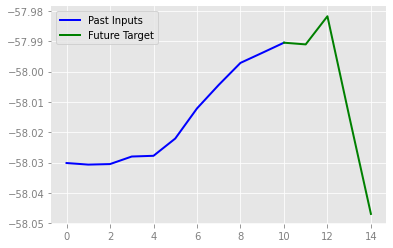

In [ ]:
from matplotlib.lines import Line2D
# Sample plot of input and target of single sequence 
# Plot all data elements in red
sample_x = list(train_data[0][:,0])
sample_y = list(target_data[0][:,0])

xy = np.array(sample_x + sample_y)
x = np.arange(len(xy))
valid,forecast = x<=len(sample_x),x>=len(sample_x)
plt.plot(x,np.ma.MaskedArray(xy,~valid),'b',x,np.ma.MaskedArray(xy,~forecast),'g')

custom_lines = [Line2D([0], [0], color='b', lw=2),
                Line2D([0], [0], color='g', lw=2)]
plt.legend(custom_lines, ['Past Inputs', 'Future Target'])
plt.show()


##### Split data


In [ ]:
from sklearn.utils import shuffle

# Shuffle the IDs and the corresponding sequence , preserving the order
train_data, target_data, target_category = shuffle(train_data, target_data, target_category)

# Train test split
split = int(0.75*len(train_data)) 

train_x = train_data[:split]
train_y = target_data[:split]
train_z = target_category[:split]

test_x = train_data[split:]
test_y = target_data[split:]
test_z = target_category[split:]

print('Train data,target, cat',len(train_x),len(train_y),len(train_z))
print('Test data,target, cat',len(test_x),len(test_y),len(test_z))


Train data,target, cat 3301 3301 3301
Test data,target, cat 1101 1101 1101


##### Scaling the data in each batch

In [ ]:
def scale_data(data, sequence_length):
    assert len(data[0].shape)==2
    scalers={}
    data = np.vstack(data)
    
    for i in range(data.shape[1]):
        scaler = MinMaxScaler(feature_range=(-1,1))
        s_s = scaler.fit_transform(data[:,i].reshape(-1,1))
        s_s=np.reshape(s_s,len(s_s))
        scalers['scaler_'+ str(i)] = scaler
        data[:,i]=s_s
    # Slice the data into batches
    data = [data[i:i + sequence_length] for i in range(0, len(data), sequence_length)]
    return data, scalers


(train_x, train_x_scaler),(train_y,train_y_scaler) = scale_data(train_x,sequence_length=10),scale_data(train_y,sequence_length=5)
(test_x,test_x_scaler),(test_y,test_y_scaler) = scale_data(test_x,sequence_length=10),scale_data(test_y,sequence_length=5)

print('Train data {} Target data {}'.format(train_x[0], train_y[0]))
print('Train data length {}, target data length {}, category length {}'.format(len(train_x),len(train_y),len(train_z)))
print('Test data length {}, target data length {}, category length {}'.format(len(test_x),len(test_y),len(test_z)))

Train data [[-0.70585212  0.66254221]
 [-0.70587927  0.66283047]
 [-0.71092018  0.6520264 ]
 [-0.71111689  0.65349046]
 [-0.71108072  0.65113697]
 [-0.71116212  0.65354166]
 [-0.7115534   0.65463402]
 [-0.71472852  0.67825049]
 [-0.71457249  0.67830928]
 [-0.71459507  0.67855771]] Target data [[-0.71175016  0.69067602]
 [-0.71082515  0.65227294]
 [-0.71078899  0.65324203]
 [-0.71115086  0.65362132]
 [-0.70547223  0.65229001]]
Train data length 3301, target data length 3301, category length 3301
Test data length 1101, target data length 1101, category length 1101


### Pytorch dataset class

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self,data, target, category):
        self.data = data
        self.target = target
        self.category = category
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        z = self.category[index]
        return x, y,z

    def __len__(self):
        return len(self.data)

### Pytorch dataloader with random weighted sampler:
To address class imbalance. This avoid model overfit to certain IDs with large samples in the dataset

In [ ]:
# Get class distribution in the dataset
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

batch_size= 20

def get_class_distribution(targets): 
    """Compute class distribution, returns number of classes and their count in the targets"""
    targets_ = np.unique(targets, return_counts=True)
    return targets_[0],targets_[1]

# Prepare weighted random sampler: 
train_target_list = torch.tensor(train_z)
test_target_list = torch.tensor(test_z)

# Number of classes and their frequencies
train_targets_, train_class_count = get_class_distribution(train_target_list)
test_targets_, test_class_count = get_class_distribution(test_target_list)

# Compute class weights
train_class_weights = 1./torch.tensor(train_class_count, dtype=torch.float)
test_class_weights = 1./torch.tensor(test_class_count, dtype=torch.float)

# Assign weights to original target list
train_class_weights_all = train_class_weights[train_target_list-1] # Note the targets start from 1, to python idx to apply,-1
test_class_weights_all = test_class_weights[test_target_list-1]

# Weighted samplers
train_weighted_sampler = WeightedRandomSampler(
    weights=train_class_weights_all,
    num_samples=len(train_class_weights_all),
    replacement=True
)
test_weighted_sampler = WeightedRandomSampler(
    weights=test_class_weights_all,
    num_samples=len(test_class_weights_all),
    replacement=True
)

# Dataset
train_dataset = TimeSeriesDataset(train_x,train_y,train_z)
test_dataset = TimeSeriesDataset(test_x,test_y,test_z)

# Dataloader with weighted samplers
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=batch_size, 
                          sampler=train_weighted_sampler,drop_last=True)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size, 
                         sampler=test_weighted_sampler, drop_last=True)

print("Number of batches in the train data loader {}".format(len(train_loader)))
print("Number of batches in the test data loader {}".format(len(test_loader)))

Number of batches in the train data loader 165
Number of batches in the test data loader 55


### Model

##### Wrapper: LSTM layers with TD linear output layer

In [ ]:
class TimeDistributed(torch.nn.Module):
    """ Time distributed wrapper compatible with linear/dense pytorch layer modules"""
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        # Linear layer accept 2D input
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        out = self.module(x_reshape)

        # We have to reshape Y back to the target shape
        if self.batch_first:
            out = out.contiguous().view(x.size(0), -1, out.size(-1))  # (samples, timesteps, output_size)
        else:
            out = out.view(-1, x.size(1), out.size(-1))  # (timesteps, samples, output_size)

        return out

#### Encoder

In [ ]:
class LSTMEncoder(torch.nn.Module):
    """ Deep LSTM network. This implementation
    returns output_size outputs.
    Args:
        input_size: The number of expected features in the input `x`
        batch_size: 
        sequence_length: The number of in each sample
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        output_size: The number of output dimensions
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
    """

    def __init__(self, input_size: int, sequence_length:int, batch_size:int, 
                 hidden_size: int, num_layers: int,
                 batch_first: bool, dropout: float, 
                 reset_state: bool, bidirectional: bool):
        
        super(LSTMEncoder, self).__init__()
        
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.dropout = dropout
        self.reset_state = reset_state
        self.bidirectional = bidirectional

        # RNN Encoder
        self.lstm_encoder = torch.nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
                            num_layers=num_layers, dropout=dropout,
                            bidirectional=self.bidirectional, batch_first=True)

    def _init_hidden(self):
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device), 
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device))

    def forward(self, x):
        
        # Encoder
        enc_init_hidden = self._init_hidden()   
        enc_output,enc_states = self.lstm_encoder(x, enc_init_hidden)
        # RNNs obeys, Markovian. Consider the last state of the hidden is the markovian of the entire sequence in that batch.
        enc_output = enc_output[ : , -1, : ] # Shape(batch_size,hidden_dim) 
        return enc_output

#### Sampler

In [ ]:
class Sampler(torch.nn.Module):
    def __init__(self):
        super(Sampler, self).__init__()
        
    def forward(self,input):
        mu = input[0]
        logvar = input[1]
        
        std = logvar.mul(0.5).exp_() #calculate the STDEV
        if device=='cuda':
            eps = torch.cuda.FloatTensor(std.size()).normal_() #random normalized noise
        else:
            eps = torch.FloatTensor(std.size()).normal_() #random normalized noise
        eps = Variable(eps)
        return eps.mul(std).add_(mu) 

#### Latent


In [ ]:
class DisentangledLatent(torch.nn.Module):
    """ Deep LSTM network. This implementation
    returns output_size outputs.
    Args:
        input_size: The number of expected features in the input `x`
        batch_size: 
        sequence_length: The number of in each sample
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        output_size: The number of output dimensions
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
    """

    def __init__(self,  hidden_size: int, latent_size:int, dropout: float):
        super(DisentangledLatent, self).__init__()
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.latent_mu = torch.nn.Linear(self.hidden_size,self.latent_size)
        self.latent_logvar = torch.nn.Linear(self.hidden_size,self.latent_size)
        self.sampler = Sampler()
        
    
    def forward(self, x, training=True):
        
        # Feed it into the disentanled latent layer
        z = self.latent_mu(x)
        logvar = self.latent_logvar(x)
        
        # Sampling
        zp = self.sampler([z,logvar])
        return z, zp, z, logvar # Duplicate z for naming convenience

#### Decoder

In [ ]:
class LSTMDecoder(torch.nn.Module):
    """ Deep LSTM network. This implementation
    returns output_size outputs.
    Args:
        input_size: The number of expected features in the input `x`
        batch_size: 
        sequence_length: The number of in each sample
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        output_size: The number of output dimensions
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
    """

    def __init__(self, batch_size:int, num_future:int, hidden_size: int, num_layers: int,
                 output_size: int, latent_size:int, batch_first: bool, dropout: float, 
                 reset_state: bool, bidirectional: bool):
        super(LSTMDecoder, self).__init__()
        
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.num_future = num_future
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.dropout = dropout
        self.reset_state = reset_state
        self.bidirectional = bidirectional

        # RNN decoder
        self.lstm_decoder = torch.nn.LSTM(input_size=self.latent_size, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, dropout=self.dropout,
                            bidirectional=self.bidirectional, batch_first=True)
        self.output = TimeDistributed(torch.nn.Linear(self.hidden_size , self.output_size))

    def _init_hidden(self):
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device), 
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device))

    def forward(self, x):
    
        # To feed the latent states into lstm decoder, repeat the tensor n_future times at second dim
        decoder_inputs = x.unsqueeze(1).repeat(1, self.num_future, 1)
        # Decoder input Shape(batch_size, num_futures, latent_size)
        dec,(dec_hidden,dec_cell) = self.lstm_decoder(decoder_inputs,self._init_hidden())
        # dec,(dec_hidden,dec_cell) = self.lstm_decoder(decoder_inputs)
    
        # Map the decoder output: Shape(batch_size, sequence_len, hidden_dim) to Time Dsitributed Linear Layer
        output = self.output(dec)
        
        return output
        # return dec

#### Classifier

In [ ]:
class MLPClassifier(torch.nn.Module):
    """ Deep MLP network
    """
    def __init__(self, hidden_size: int, num_classes:int, latent_size:int, dropout:float ):
        
        super(MLPClassifier, self).__init__()
        
        self.latent_size = latent_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.dropout = dropout
        
        # Classifier
        self.classifier1 = torch.nn.Linear(self.latent_size , self.hidden_size)
        self.classifier2 = torch.nn.Linear(self.hidden_size , self.hidden_size)
        self.classifier3 = torch.nn.Linear(self.hidden_size , self.hidden_size)
        self.classifier4 = torch.nn.Linear(self.hidden_size , self.num_classes)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        
        classifier1 = self.dropout(self.classifier1(x))
        classifier2 = self.dropout(self.classifier2(classifier1))
        classifier3 = self.dropout(self.classifier3(classifier2))
        classifier4 = self.classifier4(classifier3)
        # classifier_out = F.softmax(classifier4)

        return classifier4

#### Discriminator

In [ ]:
class LSTMDiscriminator(torch.nn.Module):
    """ Deep LSTM network. This implementation
    returns output_size outputs.
    Args:
        input_size: The number of expected features in the input `x`
        batch_size: 
        sequence_length: The number of in each sample
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        output_size: The number of output dimensions
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
    """

    def __init__(self, input_size:int, batch_size:int, num_future:int, hidden_size: int, num_layers: int,
                 output_size: int, latent_size:int, batch_first: bool, dropout: float, 
                 reset_state: bool, bidirectional: bool):
        super(LSTMDiscriminator, self).__init__()
        
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.dropout = dropout
        self.reset_state = reset_state
        self.bidirectional = bidirectional
        self.latent_size = latent_size
        self.input_size = input_size

        # RNN decoder
        self.lstm = torch.nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, dropout=self.dropout,
                            bidirectional=self.bidirectional, batch_first=True)
    
        self.fc1 = torch.nn.Linear(self.hidden_size , 10)
        self.fc2 = torch.nn.Linear(10, 10)
        self.fc3 = torch.nn.Linear(10,10)
        self.fc4 = torch.nn.Linear(10,1)
        self.relu = torch.nn.ReLU()
        self.sigmoid= torch.nn.Sigmoid()

    def _init_hidden(self):
        return (Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device), 
                Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_size)).to(device))

    def forward(self, x):
        
        # Encoder
        _init_hidden = self._init_hidden()
        lstm_out,_states = self.lstm(x)
        # lstm_out,_states = self.lstm(x,_init_hidden) # shape(lstm_out)-->[batch_size,seq_len,hidden_dim]

        # Flatten the lstm output
        lstm_out = lstm_out[ : , -1, : ] # batch_size, hidden_dim
        # fc1 =  self.relu(self.fc1(lstm_out))
        # fc2 =  self.relu(self.fc2(fc1))
        # fc3 =  self.relu(self.fc3(fc2))

        fc1 =  self.fc1(lstm_out)
        fc2 =  self.fc2(fc1)
        fc3 =  self.fc3(fc2)
        fc4 = self.fc4(fc3)
        discriminator_out =  self.sigmoid(fc4) # Binary output layer/Real or Fake
        
        return discriminator_out

### Plot helper


In [ ]:
def display_samples(target_samples,output_samples, sequence_length, input_feature_size, label):

    for N in range(1):
        
        target_samples = target_samples.data.cpu().view(-1, sequence_length,input_feature_size)
        fig,ax = plt.subplots(1,4, figsize=(18, 4))
        fig.suptitle(label + ' target / reconstructions of last sequence in a batch', color='w', fontsize=16)
        out_samples = out.data.cpu().view(-1, sequence_length, input_feature_size)
        ax[0].plot(target_samples[-1][:,0],target_samples[-1][:,1])
        ax[0].set_title(str(i), color='w')

        ax[1].plot(out_samples[-1][:,0],out_samples[-1][:,1])
        ax[1].set_title(str(i), color='w')


#### Generative and Classifier Model Encembles 

In [ ]:
class MultiModelVAEGenerator(torch.nn.Module):

    def __init__(self, input_size: int, sequence_length:int, batch_size:int, 
                 num_future:int, hidden_size: int, num_layers: int,
                 output_size: int, num_classes:int, latent_size:int, batch_first: bool, dropout: float, 
                 reset_state: bool, bidirectional: bool ):
        
        super(MultiModelVAEGenerator, self).__init__()
        self.input_size = input_size
        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.latent_size = latent_size
        self.num_future = num_future
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_classes = num_classes
        self.batch_first = batch_first
        self.dropout = dropout
        self.reset_state = reset_state
        self.bidirectional = bidirectional

        # Network instances in the model
        self.encoder = LSTMEncoder(input_size=self.input_size, sequence_length=self.sequence_length, batch_size=self.batch_size, 
                    hidden_size=self.hidden_size, num_layers=self.num_layers,
                    batch_first=self.batch_first, dropout=self.dropout, 
                    reset_state=True, bidirectional=self.bidirectional)

        self.latent = DisentangledLatent(hidden_size=self.hidden_size, latent_size=self.latent_size, dropout=self.dropout)

        self.decoder = LSTMDecoder(batch_size=self.batch_size, num_future=self.num_future, 
                        hidden_size=self.hidden_size, num_layers=self.num_layers, output_size=self.output_size, 
                        latent_size=self.latent_size, batch_first=self.batch_first, dropout=self.dropout, 
                        reset_state=True, bidirectional=self.bidirectional)

        self.sampler = Sampler()
    
    def forward(self):
        return NotImplemented

### Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
torch.autograd.set_detect_anomaly(True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 2
lstm_hidden_size = 64
lstm_num_layers = 2
num_layers = lstm_num_layers
hidden_size = lstm_hidden_size # For classifiers too
batch_first = True
reset_state = True
output_size = 2
num_classes = 9
latent_size = 20
dropout = 0.1
bidirectional = False
epochs = 20 # *2 first half for training the generative model and other for classifier
batch_size = batch_size
sequence_length = num_past 
num_future = num_future

generator = MultiModelVAEGenerator(input_size = input_size,
                        sequence_length= sequence_length,
                        batch_size = batch_size, 
                        hidden_size = lstm_hidden_size,
                        num_future = num_future, 
                        num_layers= lstm_num_layers,
                        latent_size = latent_size, 
                        output_size = output_size,
                        num_classes = num_classes,
                        batch_first = True, 
                        dropout = dropout, 
                        reset_state = reset_state,
                        bidirectional=False)

discriminator = LSTMDiscriminator(input_size = input_size, batch_size=batch_size, num_future=num_future, 
                                hidden_size=hidden_size, 
                                num_layers=num_layers, output_size=output_size, 
                                latent_size=latent_size, 
                                batch_first=batch_first, dropout=dropout, 
                                reset_state=reset_state, bidirectional= bidirectional)

classifier = MLPClassifier(hidden_size=hidden_size, 
                            num_classes=num_classes, 
                            latent_size=latent_size, 
                            dropout=dropout)

# Optimizers for each network in the model
encoder_optimizer = torch.optim.Adam(generator.encoder.parameters())
latent_optimizer = torch.optim.Adam(generator.latent.parameters())
decoder_optimizer = torch.optim.Adam(generator.decoder.parameters())
classifier_optimizer = torch.optim.Adam(classifier.parameters())
discriminator_optimizer = torch.optim.Adam(discriminator.parameters())


# Learning rate scheduler for each network in the model
# NOTE: Scheduler metric is test set loss
encoder_scheduler = ReduceLROnPlateau(encoder_optimizer, mode='max', factor=0.1, patience=2, verbose=True)
decoder_scheduler = ReduceLROnPlateau(decoder_optimizer, mode='max', factor=0.1, patience=2, verbose=True)
latent_scheduler = ReduceLROnPlateau(latent_optimizer, mode='max', factor=0.1, patience=2, verbose=True)
classifier_scheduler = ReduceLROnPlateau(classifier_optimizer, mode='max', factor=0.1, patience=2, verbose=True)
discriminator_scheduler = ReduceLROnPlateau(discriminator_optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# Discriminator criterion
discriminator_criterion = torch.nn.BCELoss()

# Classifier loss function
classifier_criterion = torch.nn.CrossEntropyLoss()

# Decoder criterion
huber_loss = torch.nn.SmoothL1Loss(reduction='sum')

# Move the model to target device
generator.to(device)
discriminator.to(device)
classifier.to(device)

# Training mode: Switch from Generative to classifier training mode
training_mode = 'forecasting'

# Training decoder and discriminator
# Training
real_label = 1
fake_label = 0
generated_label = 0

# Noise and label
noise = torch.FloatTensor(batch_size, latent_size)
label = torch.FloatTensor(batch_size)
noise = Variable(noise)
label = Variable(label)

# Discriminator loss constants
gamma = 1.0

for epoch in range(epochs*2): # First half for generative model and next for classifier
    if epoch>0: # Initial step is to test and set LR schduler
        
        # Training
        generator.train()
        discriminator.train()
        classifier.train()
        
        discriminator_total_loss = 0 # Real + Fake
        vae_total_loss = 0 # VAE loss 
        vae_disc_total_loss = 0 # VAE + Discriminator 
        discriminator_total_vae_loss = 0 # Discriminator(VAE) loss
        total_classifier_loss = 0 # Classifier loss
        for idx, (data, target,category) in enumerate(train_loader):
            
            data, target,category = data.float().to(device), target.float().to(device), category.to(device)
            
            if training_mode =='forecasting':
                for param in classifier.parameters():
                    param.requires_grad = False

                for param in generator.encoder.parameters():
                    param.requires_grad = True
                
                for param in generator.decoder.parameters():
                    param.requires_grad = True
                
                for param in generator.latent.parameters():
                    param.requires_grad = True
                ##########################################################
                #  Update Discriminator network: 
                #  maximize log(D(x)) + log(D(G(z))) + log(1 - D(G(zp))) 
                ##########################################################
                discriminator.zero_grad()
                batch_size = data.size(0)

                # Train Discriminator with Real data: log(D(x))
                # (1) Feed the original data to the discriminator
                output = discriminator(data)
                # (2) The target label is real
                label = torch.full((batch_size,), real_label, dtype=data.dtype, 
                                   device=device)
                # (3) Measure the loss and backward pass the error using discriminator optimizer
                discriminator_real_loss = discriminator_criterion(output.squeeze(), label)
                discriminator_real_loss.backward()

                # Train the discriminator with Real data: Autoencoded output: log(D(G(z))) 
                # Inference Network: input --> encoder-->latent-->decoder--> discriminator
                # (1) Feed the input
                encoder_out = generator.encoder(data)
                latent_out_z, latent_out_zp, mu, logvar = generator.latent(encoder_out,training= True)
                generator_out = generator.decoder(latent_out_zp)
                # (2) Feed this generated data to the discriminator
                output = discriminator(generator_out.detach())
                # (3) The target label is fake!
                label.data.fill_(real_label)
                # (4) Measure the loss and backward pass the error 
                discriminator_real_aeloss = discriminator_criterion(output.squeeze(), label)
                discriminator_real_aeloss.backward()
                
                # Train the discriminator with Fake: Variational autoencoded output: log(1 - D(G(zp))) 
                # Generator network: noise --> latent-->sampler-->decoder--> discriminator
                # (1) Feed the noise range N(0,1) to the latent and generate data.
                noise.data.normal_(0, 1)
                generator_out = generator.decoder(noise)
                # (2) Feed this generated data to the discriminator
                output = discriminator(generator_out.detach())
                # (3) The target label is fake!
                label.data.fill_(fake_label)
                # (4) Measure the loss and backward pass the error
                discriminator_fake_vaeloss = discriminator_criterion(output.squeeze(), label)
                discriminator_fake_vaeloss.backward()
                # (5) Optimize the discriminator parameters
                discriminator_optimizer.step()
                # For printing performance of discriminator
                discriminator_loss = discriminator_real_loss + discriminator_real_aeloss + discriminator_fake_vaeloss

                ##########################################################
                # (2) Update Generative Network: VAE + Disc(VAE)
                #  Maximize loglikelihood(P(X)) - KLD(Q(Z|X), P(Z)) - D(G(zp))
                ##########################################################
                generator.zero_grad()

                # Forward step
                # (1) Encoder
                enc_out = generator.encoder(data)
                # (2) Latent with sampler
                z, zp, mu,logvar = generator.latent(enc_out,training=True)
                # (3) Decoder
                generator_out = generator.decoder(zp)
                # (4) VAE Loss
                KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
                KLD = torch.sum(KLD_element).mul_(-0.5) # note mulitplied by -0.5 
                MSE = huber_loss(generator_out,target) # Not true MSE loss
                vae_loss= MSE + KLD 
                # (5) Backward pass
                # vae_loss.backward()
                # (6) Discriminator Loss
                discriminator_output = discriminator(generator_out.detach())
                # (7) The target label is fake!
                label.data.fill_(fake_label)
                # (8) Measure the loss and backward pass the error; 
                # =1 if disc find it Fake, Punish the generator by discriminator's success weighted by constant gamma
                discriminator_fake_vaeloss = discriminator_criterion(discriminator_output.squeeze(), label)

                # VAE + Discriminator loss
                vae_disc_loss = vae_loss + gamma*(discriminator_fake_vaeloss)
                vae_disc_loss.backward()
                # (9) Generator Optimizer step
                encoder_optimizer.step()
                latent_optimizer.step()
                decoder_optimizer.step()
                
                discriminator_total_loss+= discriminator_loss.item() # Real + Fake
                vae_total_loss += vae_loss.item() # VAE loss 
                vae_disc_total_loss += vae_disc_loss.item() # VAE + Discriminator 
                discriminator_total_vae_loss += discriminator_fake_vaeloss.item() # Discriminator(VAE) loss

            if training_mode !='forecasting':

                classifier.zero_grad()

                for param in classifier.parameters():
                    param.requires_grad = True

                for param in generator.encoder.parameters():
                    param.requires_grad = False
                
                for param in generator.decoder.parameters():
                    param.requires_grad = False
                
                for param in generator.latent.parameters():
                    param.requires_grad = False

                # input-->encoder-->latent-->classifier
                # (1) Feed data to encoder
                encoder_out = generator.encoder(data)
                # (2) Latent without sampling
                z, zp, mu,logvar = generator.latent(enc_out)
                # (3) Feed the latent vector to classifier
                classifier_out = classifier(z.detach())
                # (4) Cross entropy loss
                classifier_loss = classifier_criterion(classifier_out, 
                                                       category-1)
                total_classifier_loss+=classifier_loss.item()
                # (5) Backward pass
                classifier_loss.backward()
                # (6) Classifier optimizer step
                classifier_optimizer.step()

        print('Epoch {} | {} loss {}'.format(epoch, 
                                            training_mode, 
                                            total_classifier_loss/(idx+1)))
        
        print('Epoch {} | Discriminator Real+Fake Loss {} | VAE loss {} | VAE+Discriminator Loss {} | Discriminator(Generated) Loss {}'.format(epoch, 
                                                                                                                        discriminator_total_loss/(idx+1), 
                                                                                                                        vae_total_loss/(idx+1), 
                                                                                                                        vae_disc_total_loss/(idx+1), 
                                                                                                                        discriminator_total_vae_loss/(idx+1)))        
        if epoch+1 == epochs:
            training_mode = 'classification'

    # Testing
    if epoch%2==0:
        with torch.no_grad():
            generator.eval()
            discriminator.eval()
            classifier.eval()
            test_loss_discrimination = 0  # Discriminator(VAE)
            test_loss_forecasting = 0 # Huber(VAE, target)
            test_loss_classification = 0 # CrossEntropy(Classifier, target_category)

            for idx, (data, target,category) in enumerate(list(test_loader)):
                data, target, category = data.float().to(device), target.float().to(device), category.to(device)

                # Forward step
                # (1) Encoder
                enc_out = generator.encoder(data)
                # (2) Latent with sampler
                z, zp, mu,logvar = generator.latent(enc_out,training=False)
                # (3) Decoder
                generator_out = generator.decoder(zp)
                # (4) VAE Loss
                KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
                KLD = torch.sum(KLD_element).mul_(-0.5) # note mulitplied by -0.5 
                MSE = huber_loss(generator_out,target) # Not true MSE loss
                vae_loss= MSE + KLD 
                # (5) Discriminator Loss
                discriminator_output = discriminator(generator_out.detach())
                # (6) The target label is real!
                label.data.fill_(real_label)
                discriminator_real_vaeloss = discriminator_criterion(discriminator_output.squeeze(), label)
                
                # VAE + Discriminator loss
                vae_disc_loss = vae_loss - gamma*(discriminator_real_vaeloss)
                
                # Classifier(z); Assumption, Discriminator should agree!  
                classifier_out= classifier(z.detach())

                test_loss_discrimination +=discriminator_real_vaeloss
                test_loss_forecasting += vae_loss.item()
                test_loss_classification += classifier_criterion(classifier_out, category-1).item()

        test_loss_forecasting /= len(test_loader.dataset)
        test_loss_discrimination /= len(test_loader.dataset)
        test_loss_classification /= len(test_loader.dataset)

        print(f'====> Test set Generator loss: {test_loss_forecasting:.4f}')
        print(f'Discriminator loss: {test_loss_forecasting:.4f}')
        print(f'Classifier loss: {test_loss_classification:.4f}')


====> Test set Generator loss: 2.9543
Discriminator loss: 2.9543
Classifier loss: 0.1100
Epoch 1 | forecasting loss 0.0
Epoch 1 | Discriminator Real+Fake Loss 1.4969376715746794 | VAE loss 38.39406933639989 | VAE+Discriminator Loss 39.21277913758249 | Discriminator(Generated) Loss 0.8187097336306717
Epoch 2 | forecasting loss 0.0
Epoch 2 | Discriminator Real+Fake Loss 1.3243479642001066 | VAE loss 24.302276224078554 | VAE+Discriminator Loss 25.124385446490663 | Discriminator(Generated) Loss 0.8221092003764529
====> Test set Generator loss: 1.1966
Discriminator loss: 1.1966
Classifier loss: 0.1103
Epoch 3 | forecasting loss 0.0
Epoch 3 | Discriminator Real+Fake Loss 1.3264039653720279 | VAE loss 23.014924066716976 | VAE+Discriminator Loss 23.842828918225837 | Discriminator(Generated) Loss 0.8279048916065331
Epoch 4 | forecasting loss 0.0
Epoch 4 | Discriminator Real+Fake Loss 1.3380712733124243 | VAE loss 19.71134366122159 | VAE+Discriminator Loss 20.51636847293738 | Discriminator(Gener

### Model save, load and test


In [ ]:
gen_PATH = "generator_model.pt"
torch.save(generator.state_dict(), gen_PATH)
disc_PATH = "discriminator_model.pt"
torch.save(discriminator.state_dict(), disc_PATH)
class_PATH = "classifier_model.pt"
torch.save(classifier.state_dict(), class_PATH)

# Load
generator_model = MultiModelVAEGenerator(input_size = input_size,
                        sequence_length= sequence_length,
                        batch_size = batch_size, 
                        hidden_size = lstm_hidden_size,
                        num_future = num_future, 
                        num_layers= lstm_num_layers,
                        latent_size = latent_size, 
                        output_size = output_size,
                        num_classes = num_classes,
                        batch_first = True, 
                        dropout = dropout, 
                        reset_state = reset_state,
                        bidirectional=False)
generator_model.load_state_dict(torch.load(gen_PATH))
 
disc_model= LSTMDiscriminator(input_size = input_size, batch_size=batch_size, num_future=num_future, 
                                hidden_size=hidden_size, 
                                num_layers=num_layers, output_size=output_size, 
                                latent_size=latent_size, 
                                batch_first=batch_first, dropout=dropout, 
                                reset_state=reset_state, bidirectional= bidirectional)
disc_model.load_state_dict(torch.load(disc_PATH))
class_model = MLPClassifier(hidden_size=hidden_size, 
                            num_classes=num_classes, 
                            latent_size=latent_size, 
                            dropout=dropout)

class_model.load_state_dict(torch.load(class_PATH))

<All keys matched successfully>

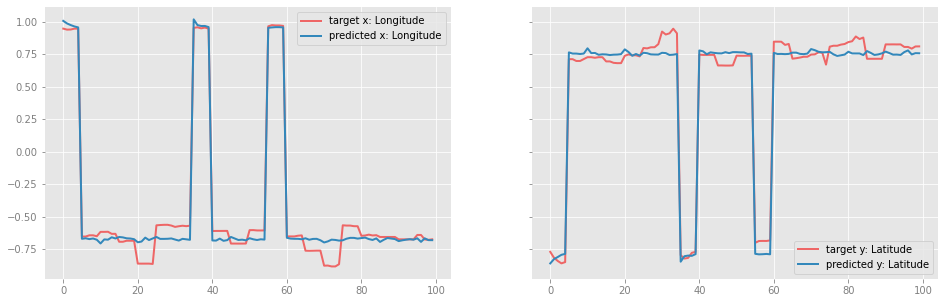

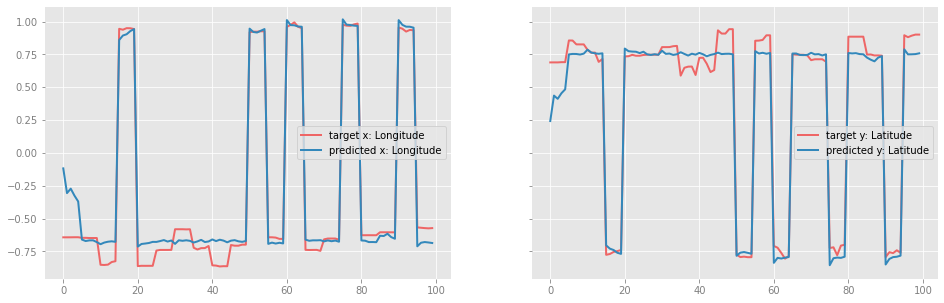

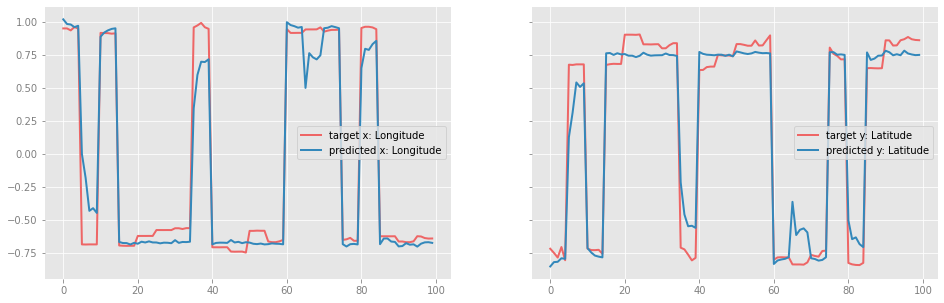

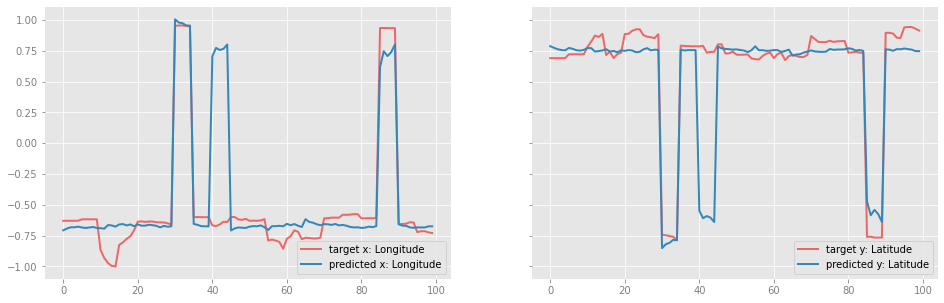

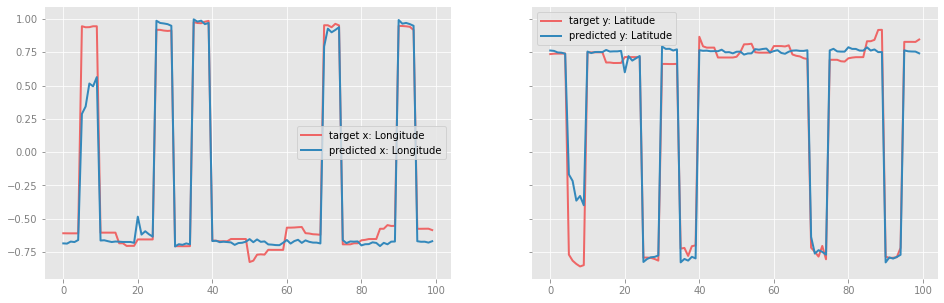

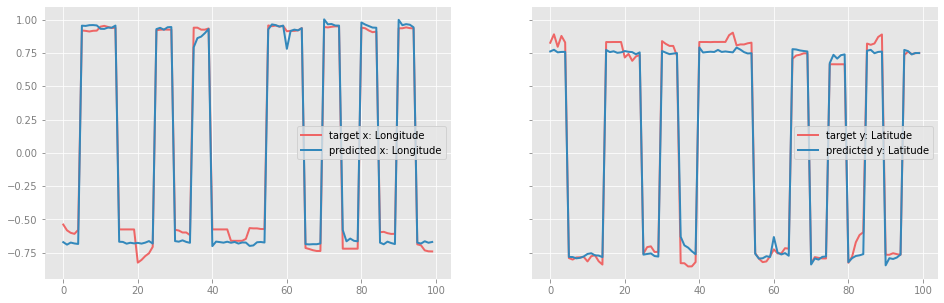

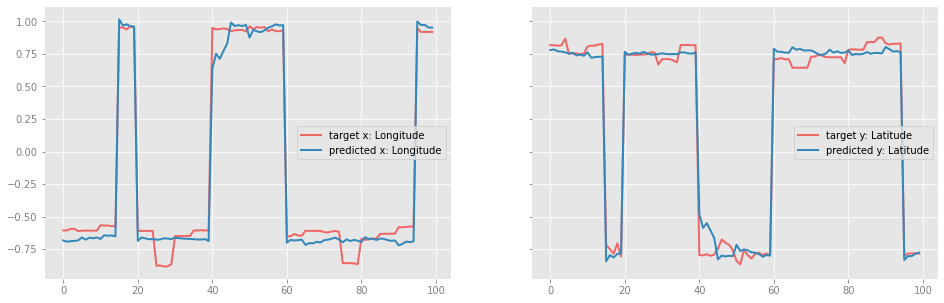

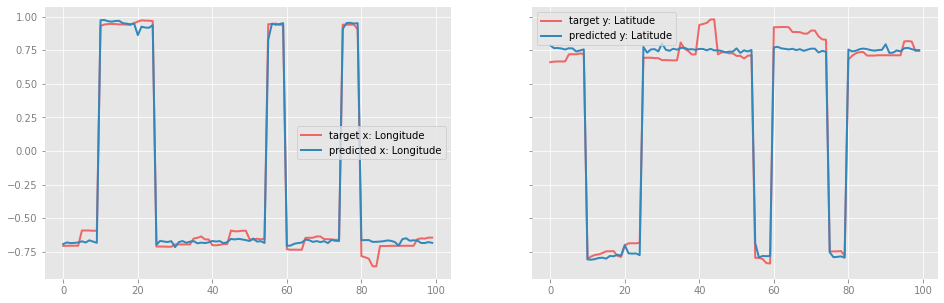

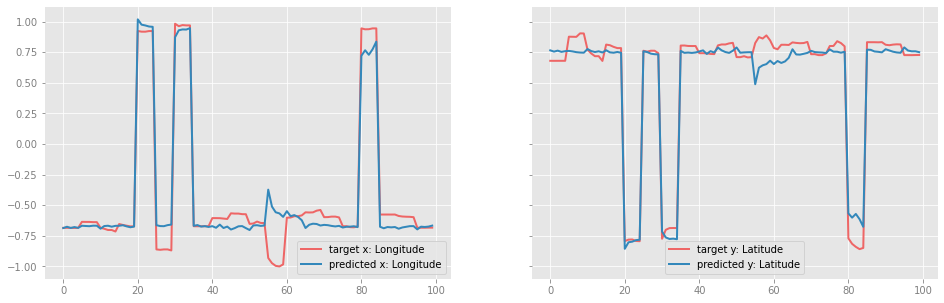

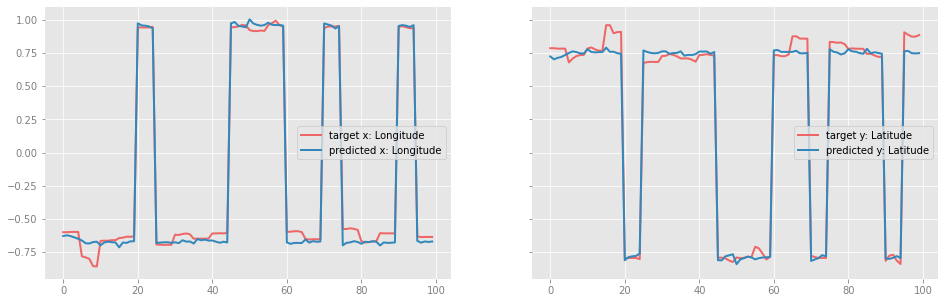

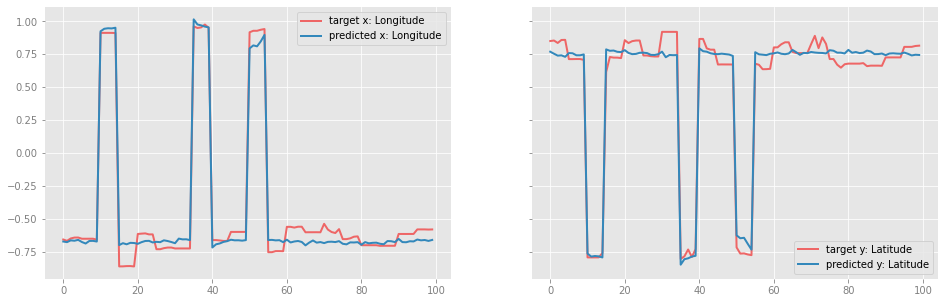

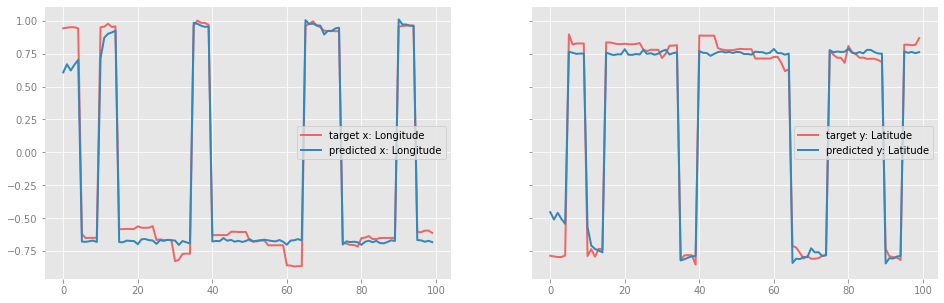

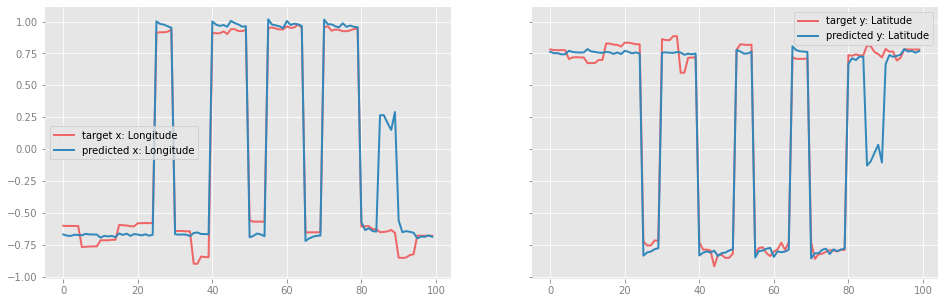

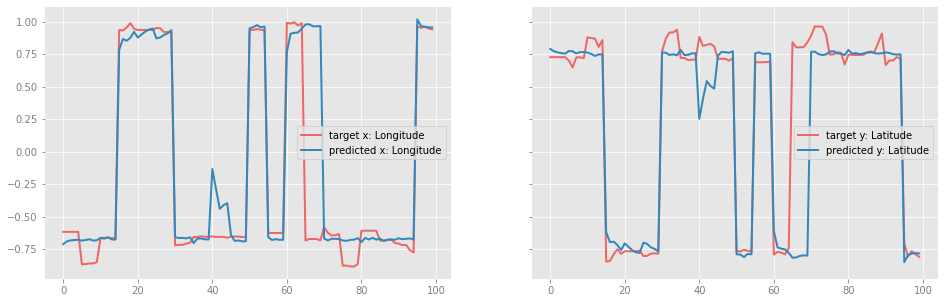

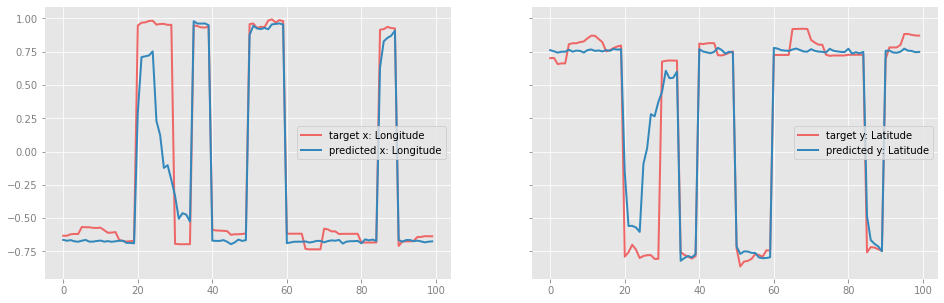

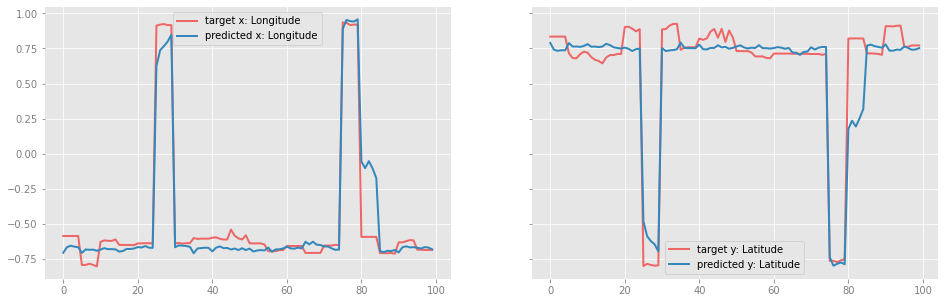

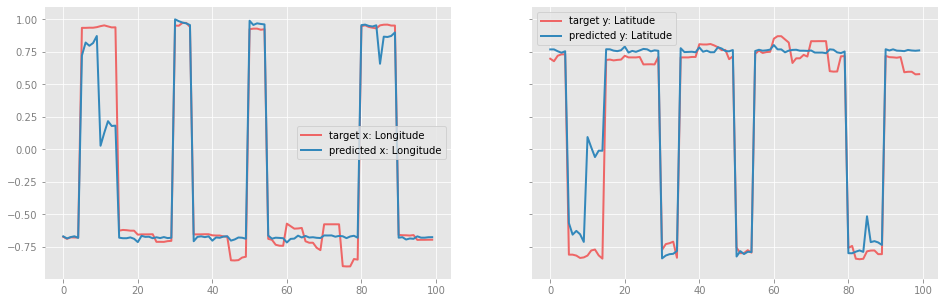

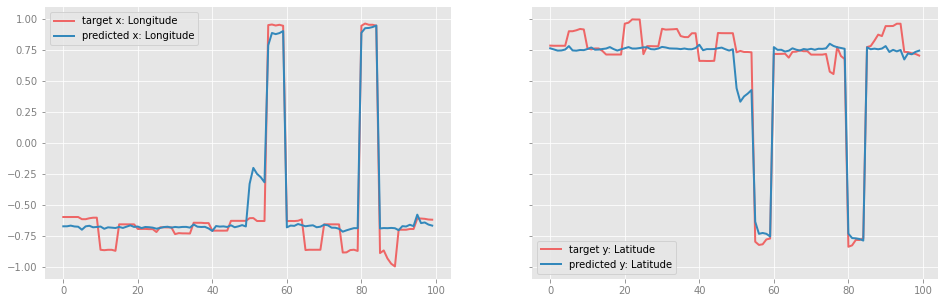

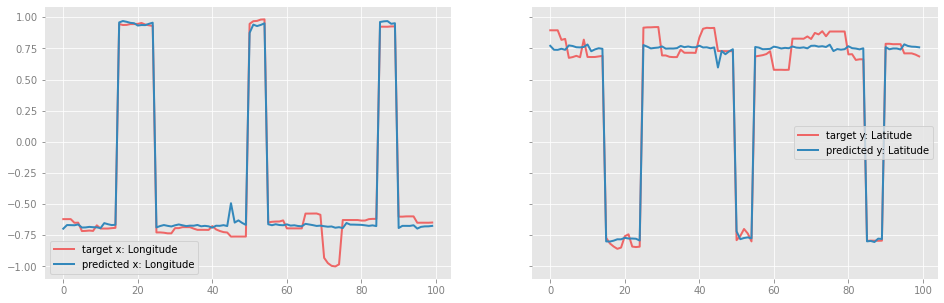

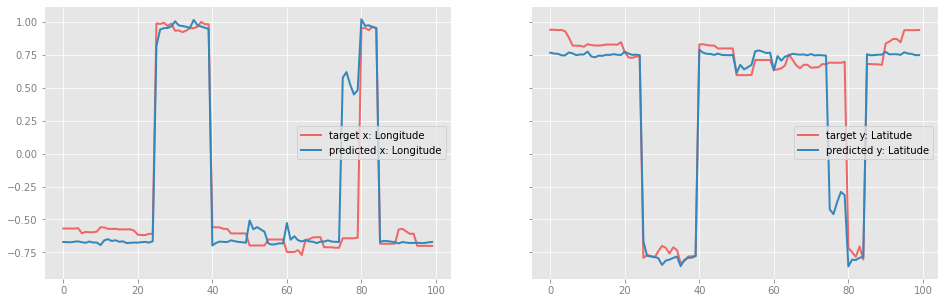

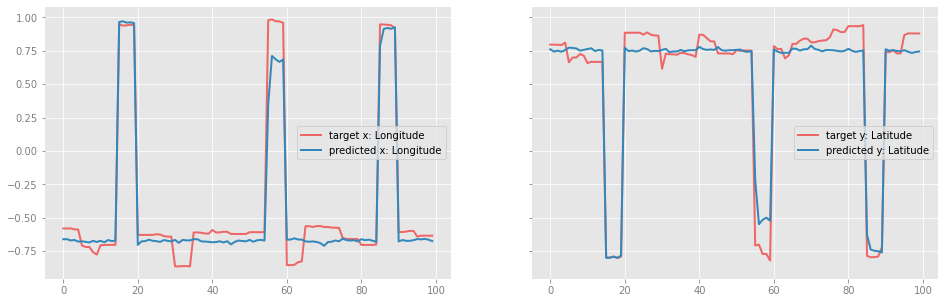

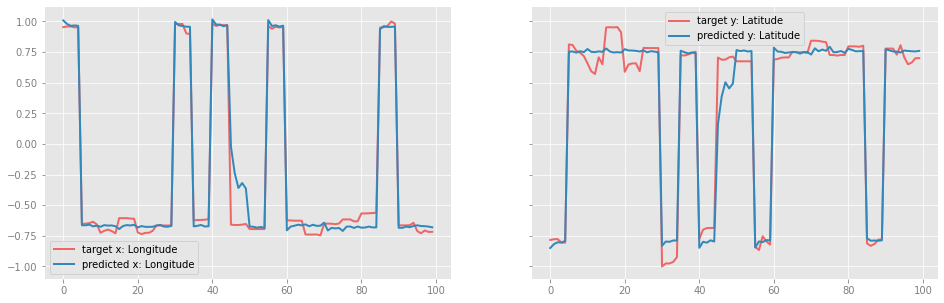

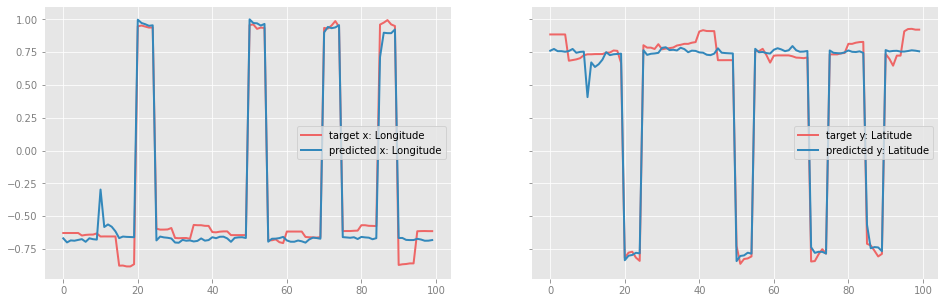

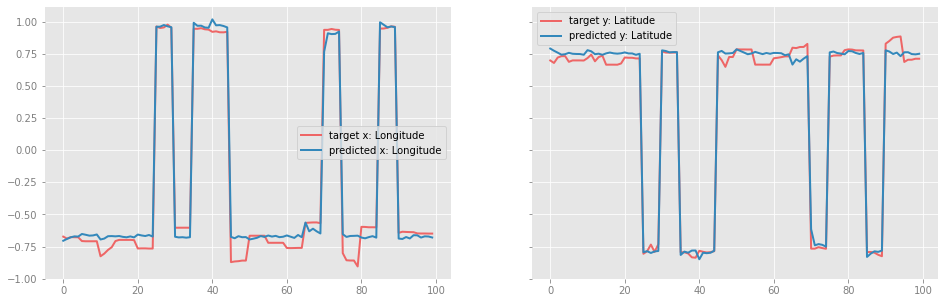

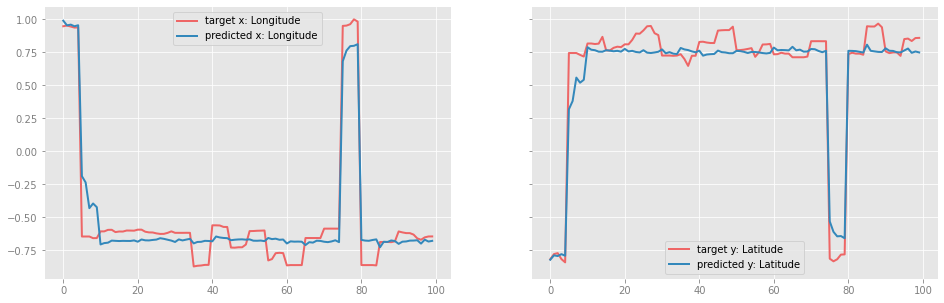

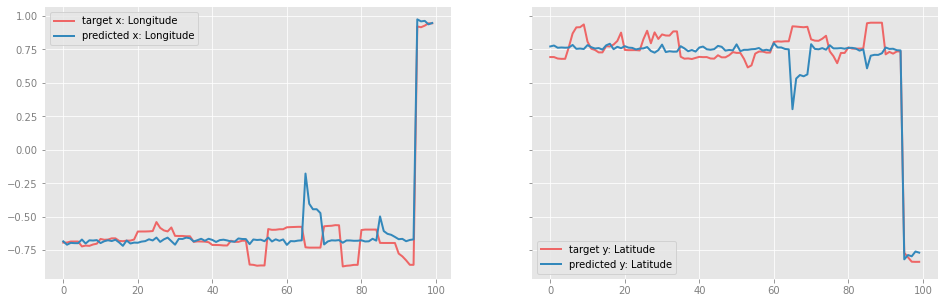

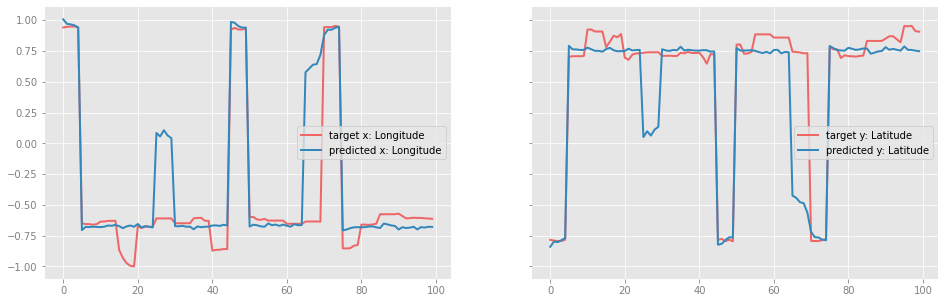

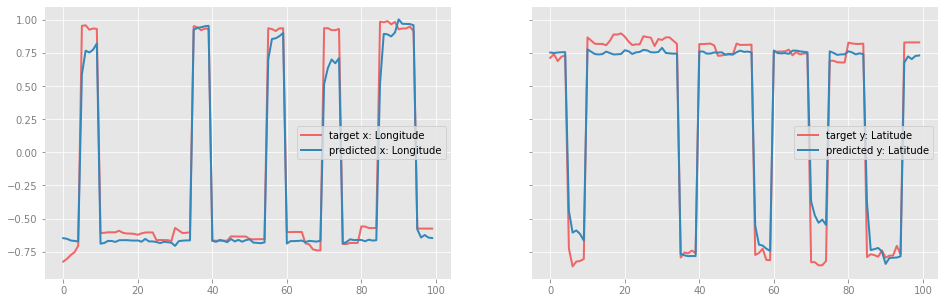

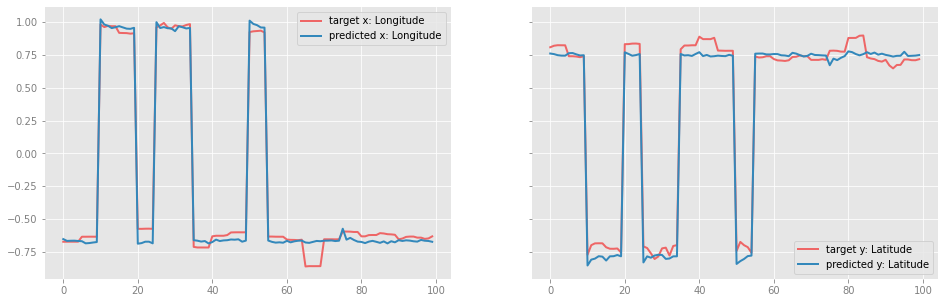

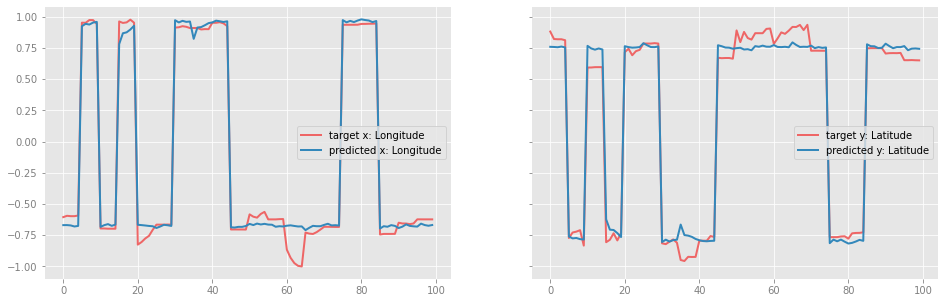

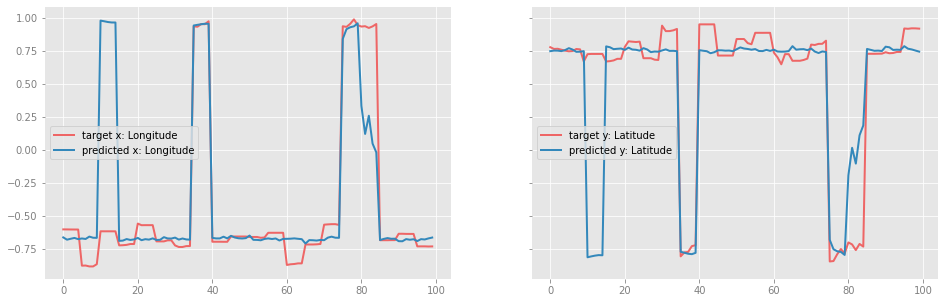

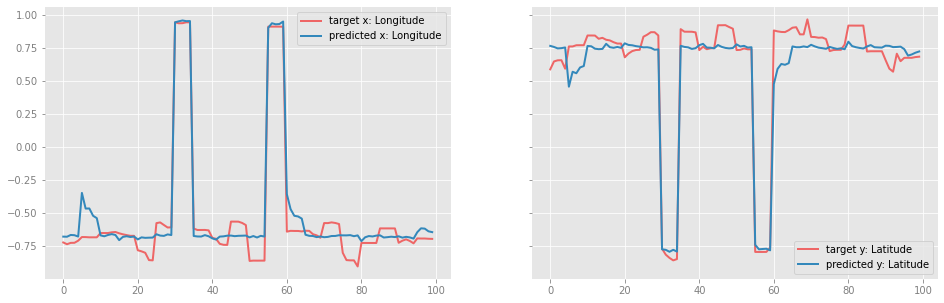

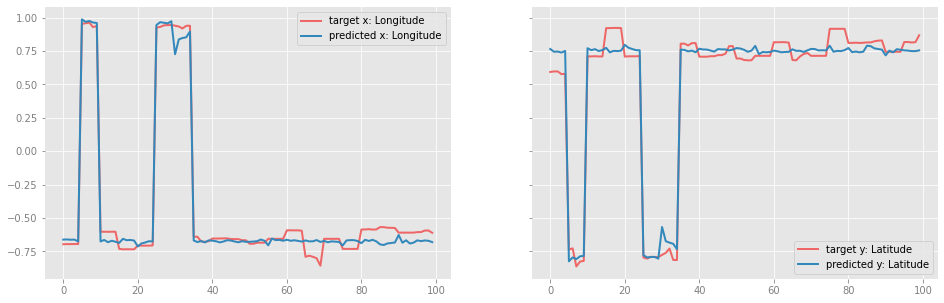

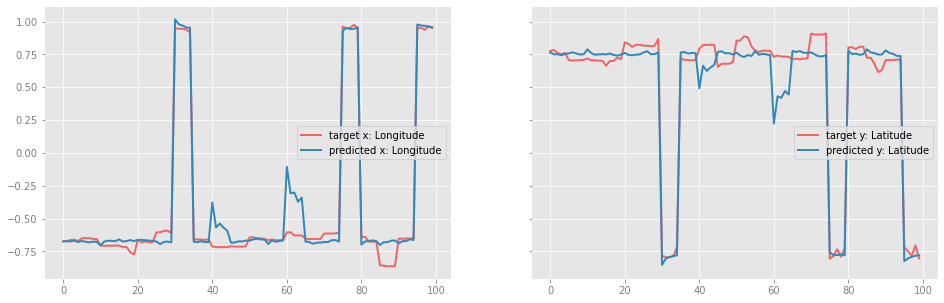

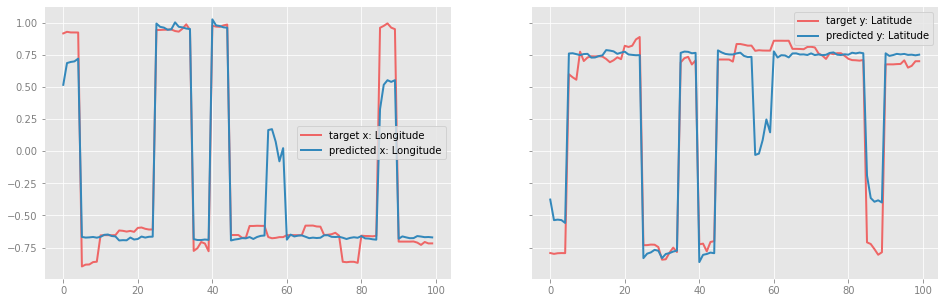

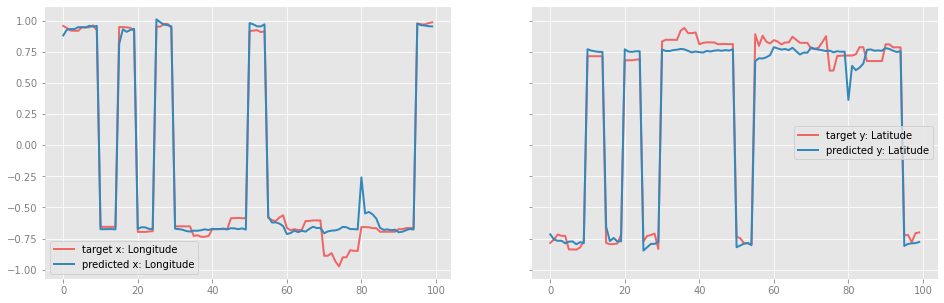

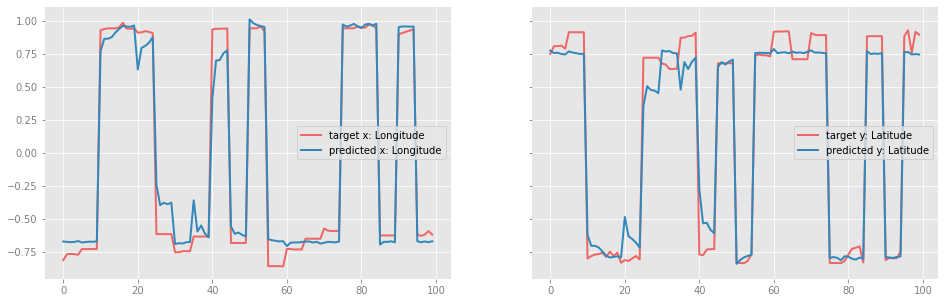

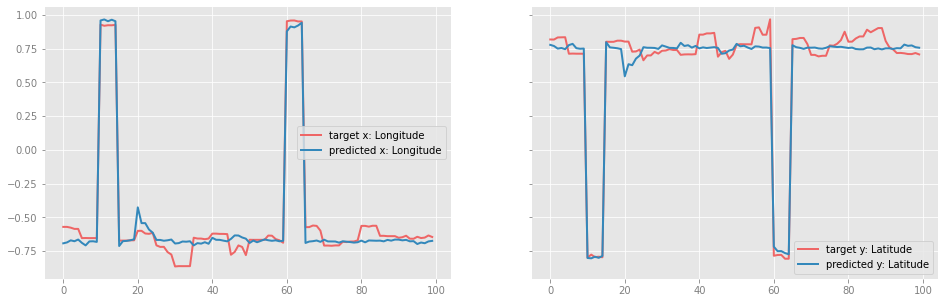

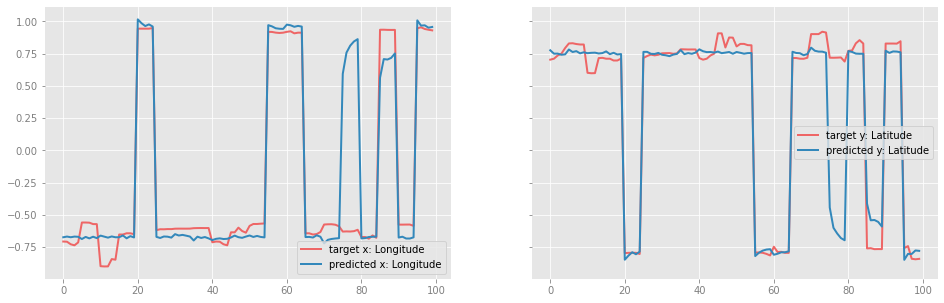

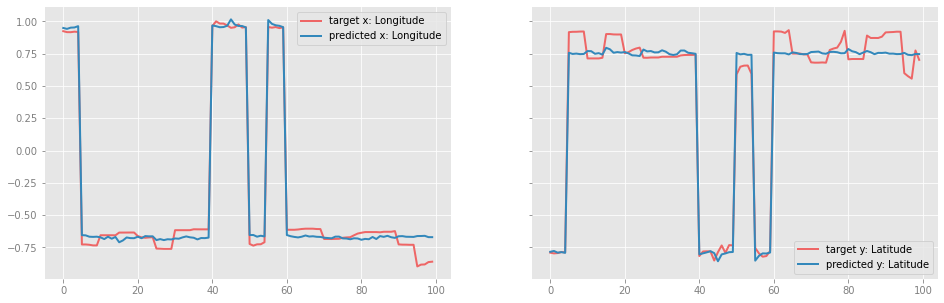

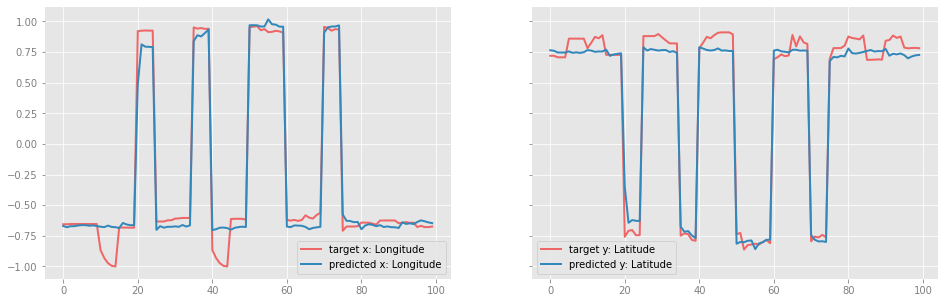

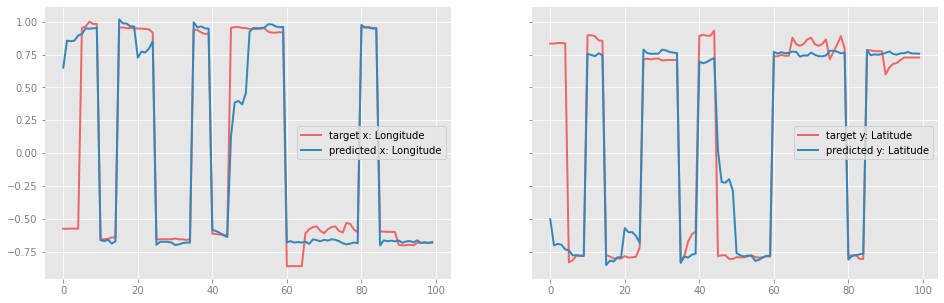

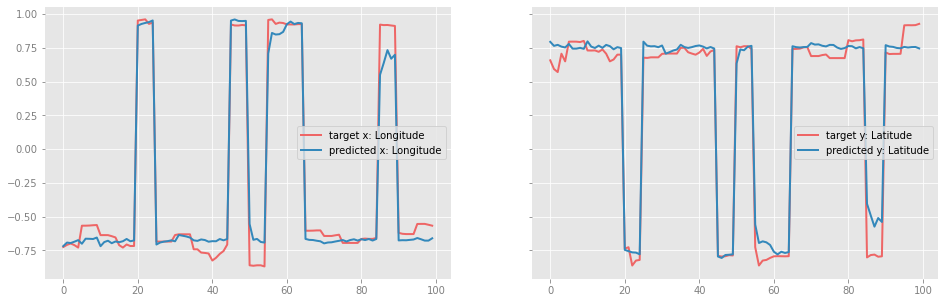

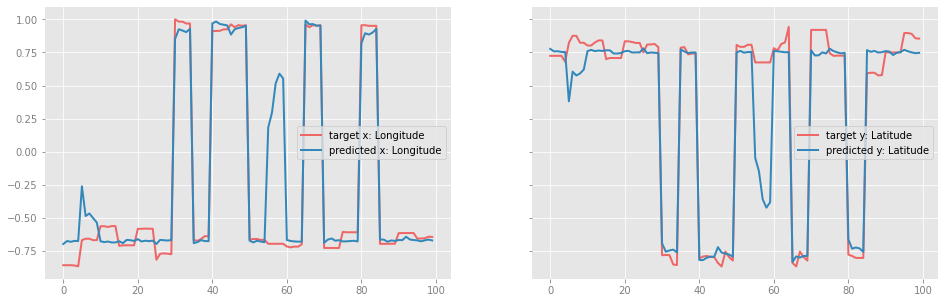

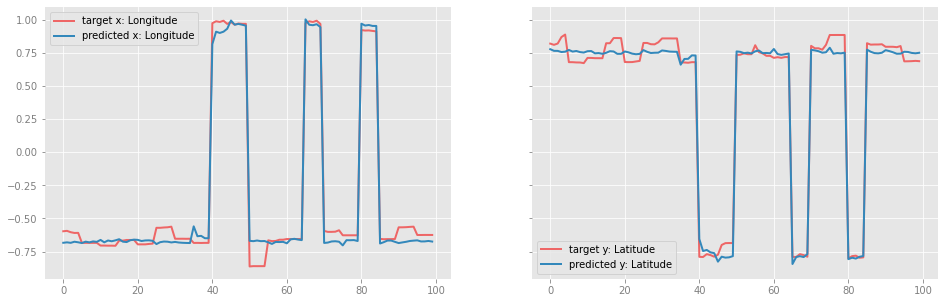

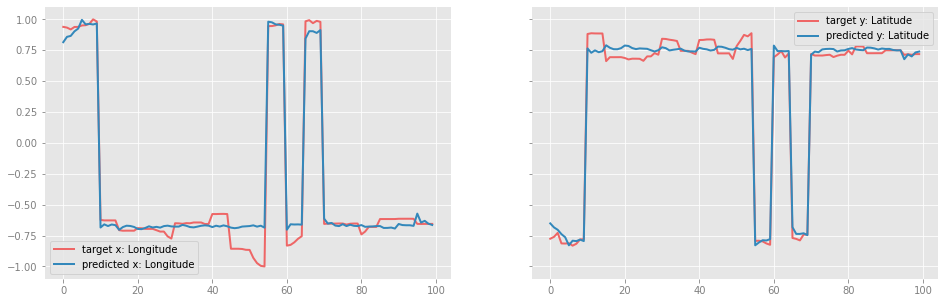

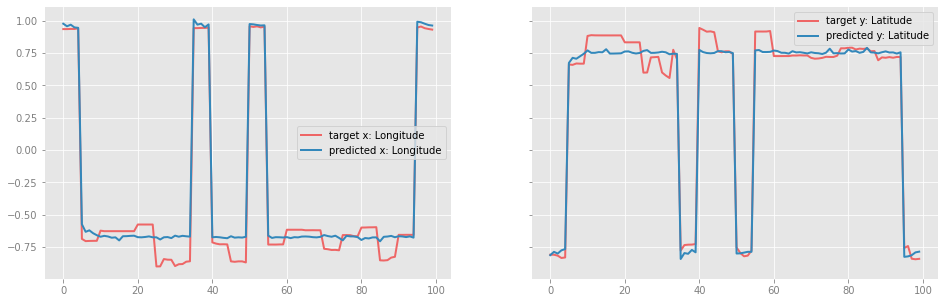

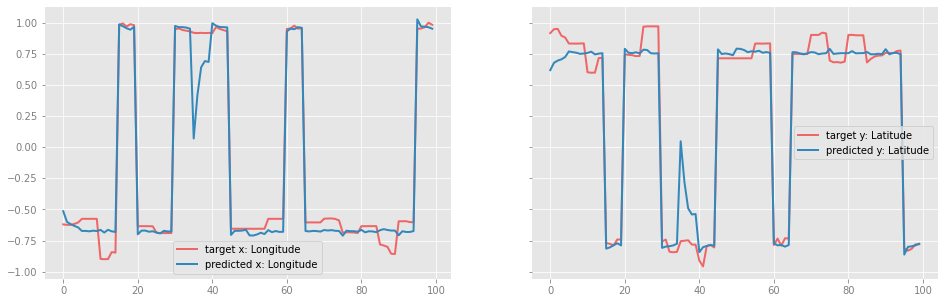

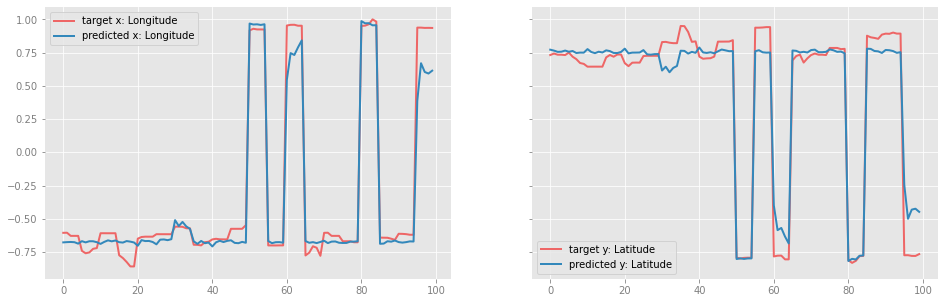

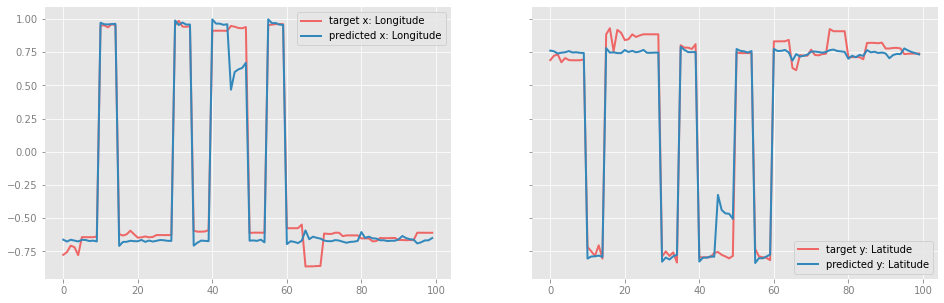

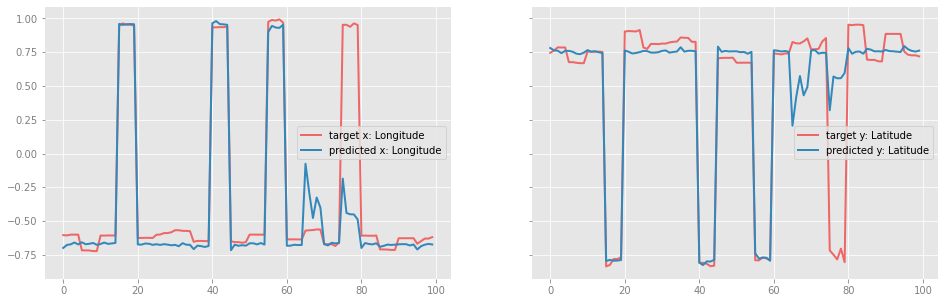

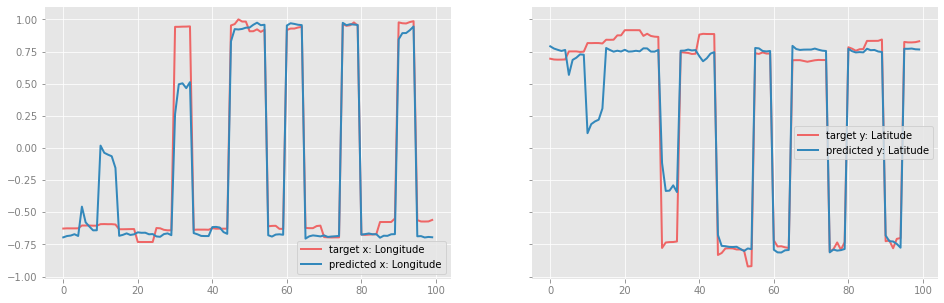

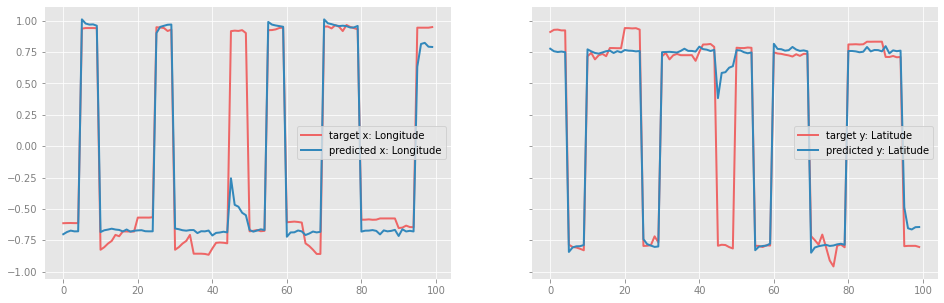

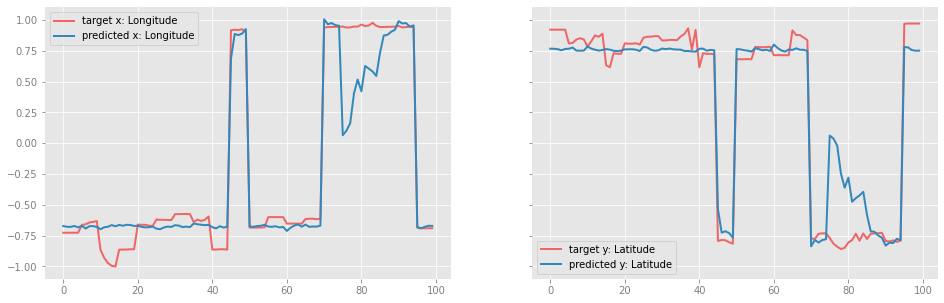

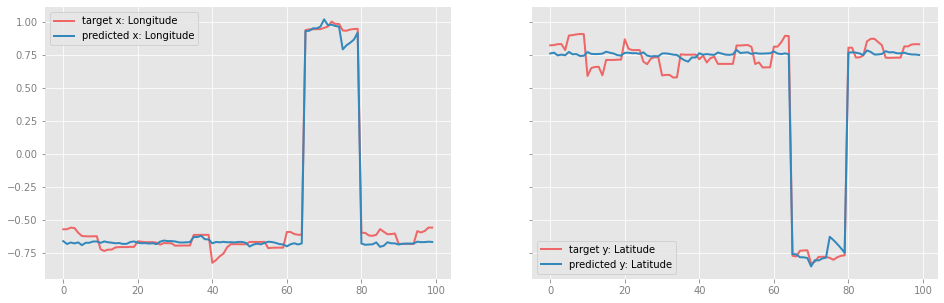

In [ ]:
generator_model.to(device)
for data,target, category in test_loader:

    enc_out = generator.encoder(data.float().to(device))
    z, zp, mu,logvar = generator.latent(enc_out,training=True)
    out = generator.decoder(zp)

    # out, latent, mu, logvar = generator_model(data.float().to(device))
    target = target.cpu().detach().numpy()
    target = target.reshape(target.shape[0]*target.shape[1],target.shape[2])
    out = out.cpu().detach().numpy()
    out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])
    
    # plt.plot(target[:,0],target[:,1],label='Target before scaling')
    # plt.legend()
    # plt.show()
    # plt.plot(out[:,0],out[:,1],label='output before scaling')
    # plt.legend()
    # plt.show()
    
    # for index, i in enumerate(list(range(target.shape[1]))):
    #     scaler = scalers['scaler_'+str(i)]
    #     target[:,index] = scaler.inverse_transform(target[:,index].reshape(1, -1))
    #     out[:,index] = scaler.inverse_transform(out[:,index].reshape(1, -1))
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

    plt.ticklabel_format(useOffset=False)
    ax[0].plot(target[:,0], label="target x: Longitude")
    ax[0].plot(out[:,0], label='predicted x: Longitude')
    ax[0].legend()
    ax[1].plot(target[:,1], label="target y: Latitude")
    ax[1].plot(out[:,1], label='predicted y: Latitude')
    ax[1].legend()
    plt.show()   


In [ ]:
# Plot all 2D combination of latent space
import plotly.express as px

def DisplayLatentDynamics(latent):
    r"""Visualize the dynamics of combination of latents 
    Args:
    latent(tensor): Each point in the list is latent's state at the end of a sequence of each batch.
    Latent shape (batch_size, latent_dim)"""
    
    latents = {}
    latents.fromkeys(list(range(latent.shape[1]))) 
    for i in range(latent.shape[1]):
        latents[f'{i}']=latent[:,i].cpu().detach().numpy()
    fig= px.scatter_matrix(latents)
    fig.update_layout(
    autosize=False,
    width=1600,
    height=1000,)
    return fig.show()


In [ ]:
DisplayLatentDynamics(mu)

### Freely generate samples using Trained Decoder

IDs in this batch of synthetic data tensor([6, 2, 2, 7, 7, 6, 7, 4, 7, 4, 4, 6, 7, 5, 6, 6, 3, 7, 2, 7])
Discrimator(Generated) [[0.5952903 ]
 [0.5246563 ]
 [0.22727585]
 [0.49091798]
 [0.64783186]
 [0.51176625]
 [0.37345323]
 [0.6807352 ]
 [0.46766323]
 [0.56219584]
 [0.52219033]
 [0.53725964]
 [0.6772704 ]
 [0.6426127 ]
 [0.5085992 ]
 [0.5653904 ]
 [0.60748935]
 [0.5390765 ]
 [0.4908029 ]
 [0.6328019 ]]


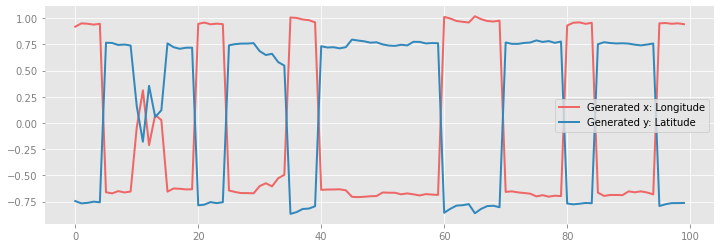

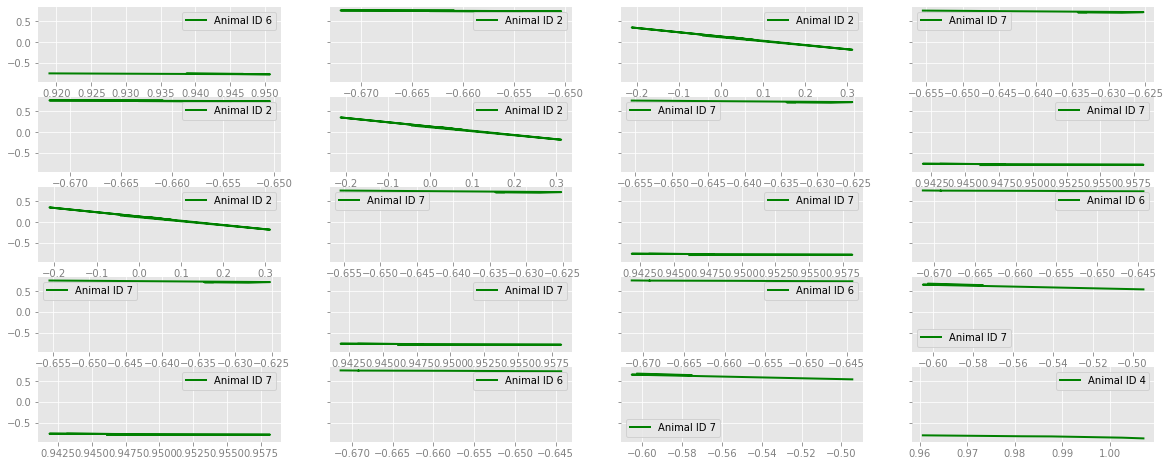

In [ ]:
 # Generating few samples
batch_size = 10 # Number of samples
num_future = 5 # Number of time steps in each sample

# Noise
# z = torch.randn((batch_size, latent_size)).to(device)
z = torch.empty(20, latent_size).normal_(mean=1,std=4.).to(device)
# Category from the noise
cat = classifier(z)
# Generate trajectories from the noise
out = generator.decoder(z)
disc = discriminator(out)
out = out.cpu().detach().numpy()
out = out.reshape(out.shape[0]*out.shape[1],out.shape[2])

# for index, i in enumerate(train_df.columns):
#     scaler = scalers['scaler_'+i]  
#     out[:,index] = scaler.inverse_transform(out[:,index].reshape(1, -1))
print('IDs in this batch of synthetic data',torch.max(cat,1).indices+1)
print('Discrimator(Generated)',disc.cpu().detach().numpy())
plt.figure(figsize=(12,4))
plt.plot(out[:,0], label='Generated x: Longitude')
plt.plot(out[:,1], label='Generated y: Latitude')
plt.legend()

fig, ax = plt.subplots(nrows=5, ncols= 4, figsize=(16, 5), sharey=True)
# plt.ticklabel_format(useOffset=False)
fig.set_size_inches(20,8)
for i in range(5):
    for j in range(4):
        ax[i,j].plot(out[:,0][(i+j)*num_future:(i+j)*num_future + num_future],out[:,1][(i+j)*num_future:(i+j)*num_future+ num_future],label = 'Animal ID {}'.format((torch.max(cat,1).indices+1).detach()[i+j]),color='g')

        ax[i,j].legend()
plt.show()
 

### Using the test data, generate time series